In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Load the dataset
df = pd.read_csv('data/obecity_prediction.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()

Dataset Shape: (2111, 17)

Data Types:
 Gender             object
Age               float64
Height            float64
Weight            float64
family_history     object
FAVC               object
FCVC              float64
NCP               float64
CAEC               object
SMOKE              object
CH2O              float64
SCC                object
FAF               float64
TUE               float64
CALC               object
MTRANS             object
Obesity            object
dtype: object

Missing Values:
 Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

First few rows of the dataset:


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


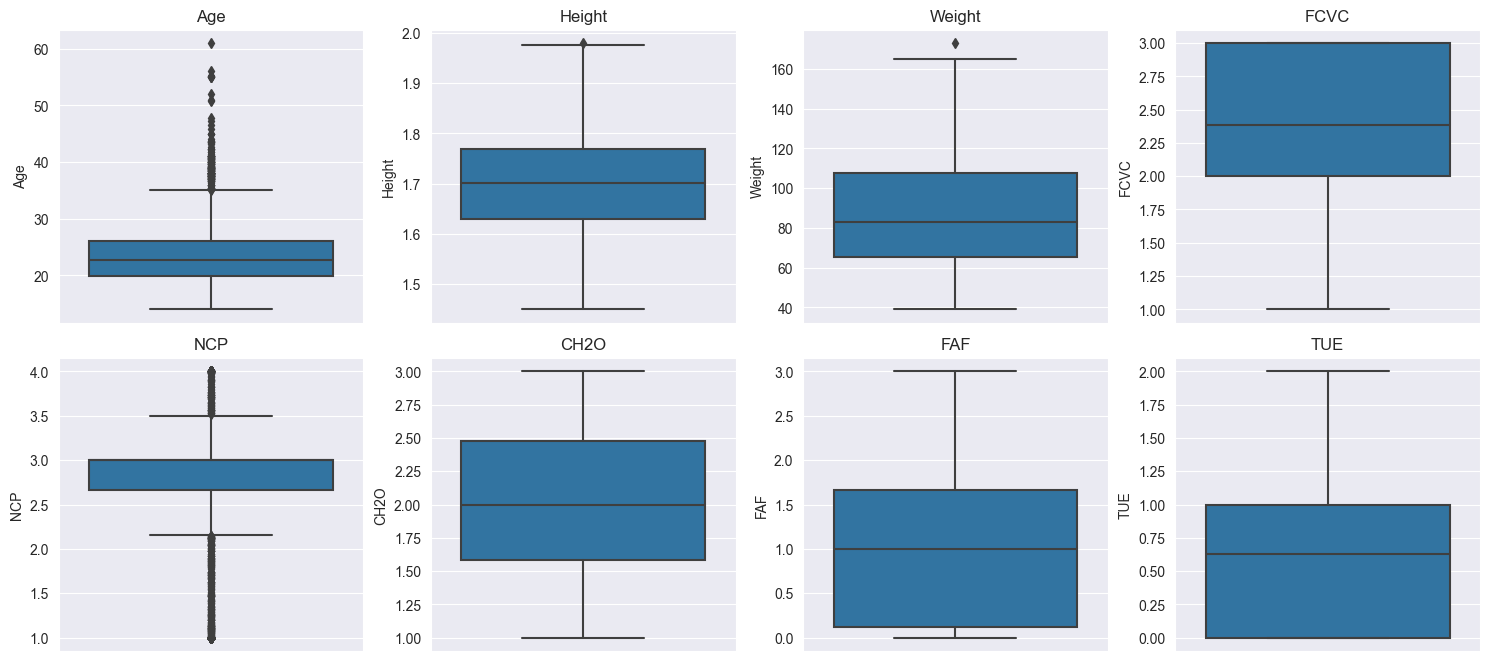

In [19]:
# Check outliers in numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df, y=feature)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [20]:
# Remove outliers for age (keep age <= 50)
df = df[df['Age'] <= 50]

In [5]:
# FCVC: round to integer value, categorical
df['FCVC'] = df['FCVC'].round().astype(int)
# CH2O: round to integer value, categorical
df['CH2O'] = df['CH2O'].round().astype(int)
# FAF: round to integer value, categorical
df['FAF'] = df['FAF'].round().astype(int)
# TUE: round to integer value, categorical
df['TUE'] = df['TUE'].round().astype(int)

In [22]:
# Create BMI feature
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity']

for column in categorical_columns:
    df[column + '_encoded'] = le.fit_transform(df[column])

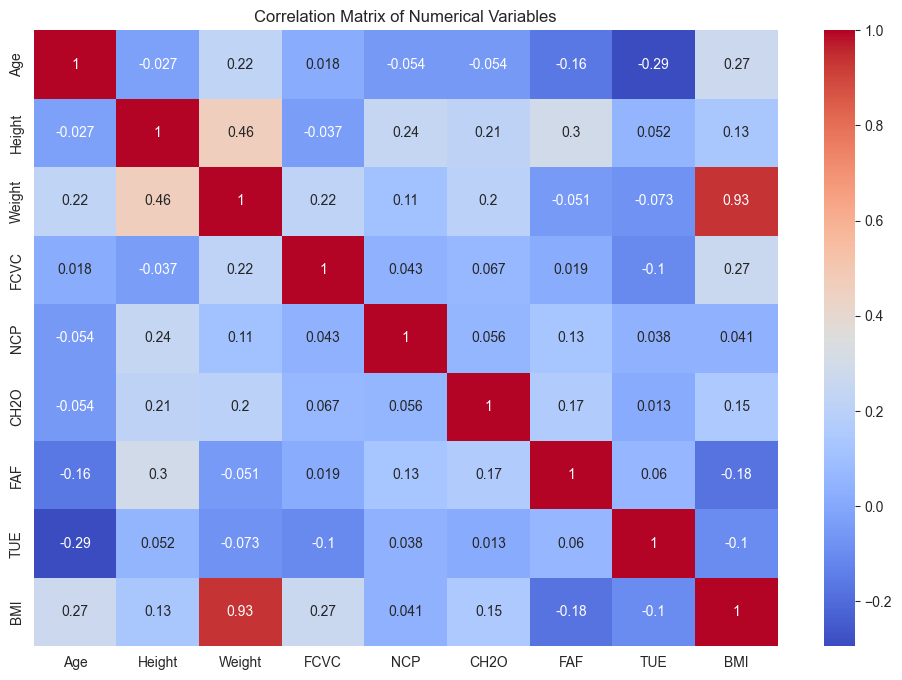

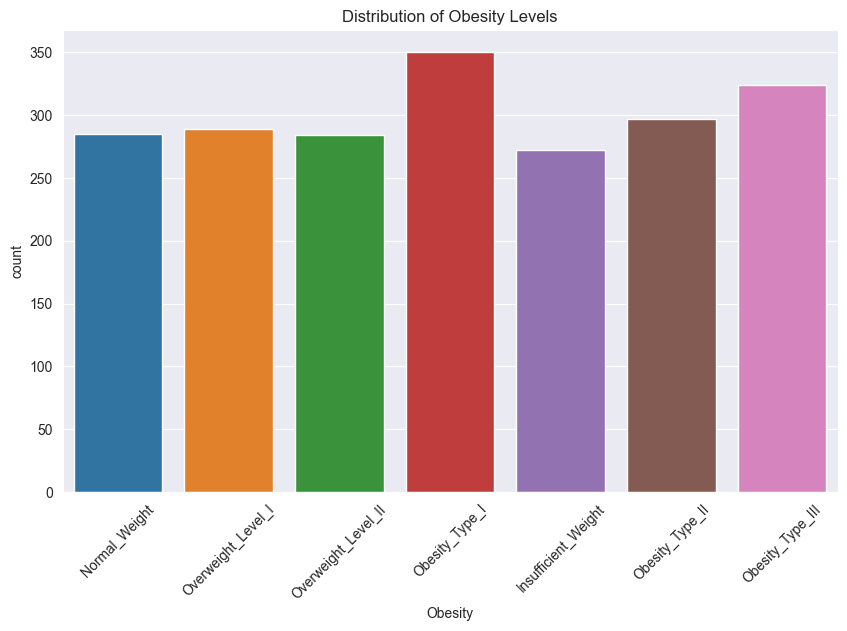

In [23]:
# Correlation matrix for numerical variables
numerical_columns = df.select_dtypes(include=['float64']).columns
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Distribution of obesity levels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Obesity')
plt.xticks(rotation=45)
plt.title('Distribution of Obesity Levels')
plt.show()

In [24]:
# Select features for the model
feature_columns = [col for col in df.columns if col.endswith('_encoded') and col != 'Obesity_encoded']
feature_columns.extend(['BMI',
                        'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])

X = df[feature_columns]
y = df['Obesity_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-validation Score: 0.9935070692266059



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        55
           1       0.97      1.00      0.98        64
           2       1.00      1.00      1.00        73
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        61
           5       1.00      1.00      1.00        54
           6       1.00      1.00      1.00        64

    accuracy                           1.00       421
   macro avg       1.00      0.99      1.00       421
weighted avg       1.00      1.00      1.00       421



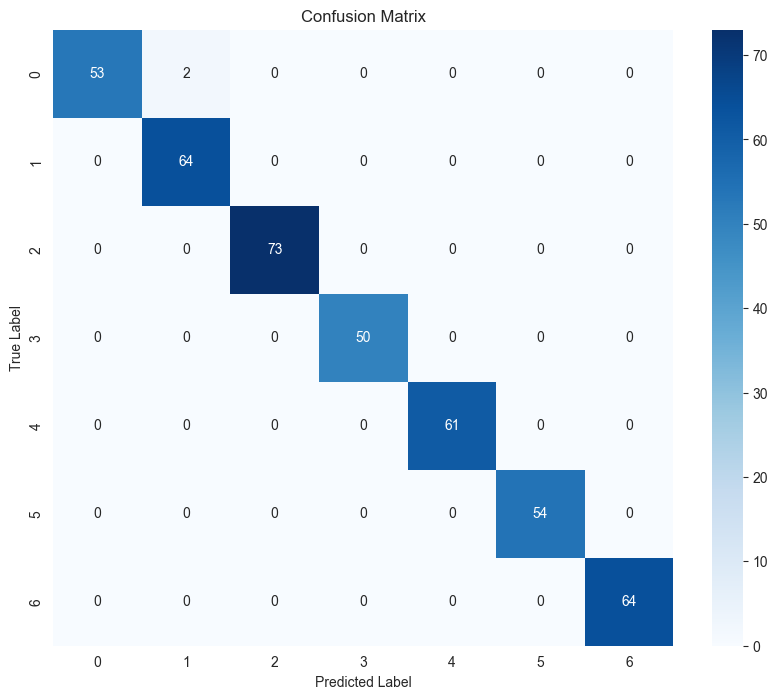

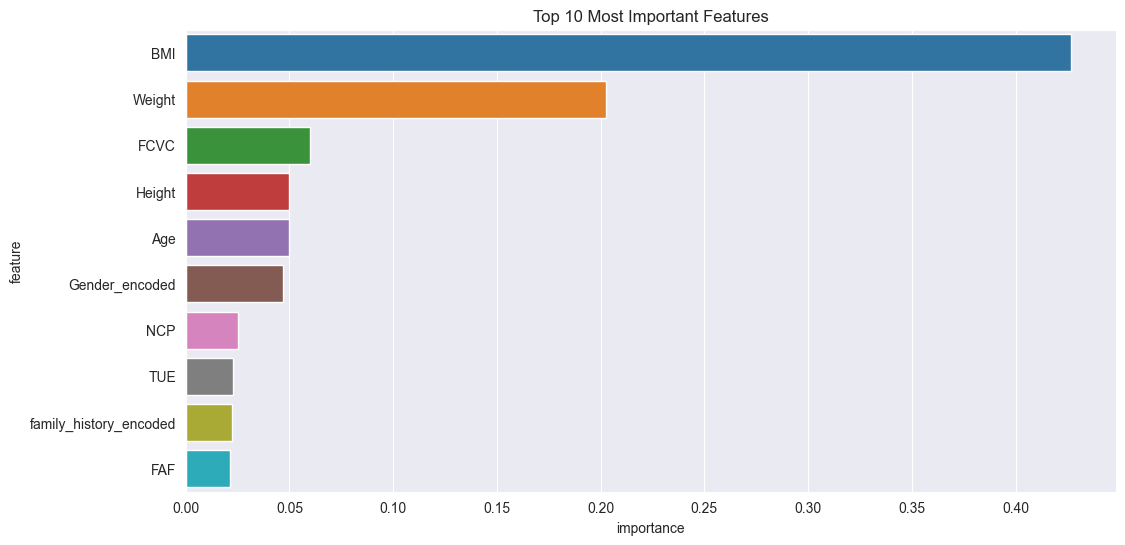

In [26]:
# Make predictions
y_pred = grid_search.predict(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': grid_search.best_estimator_.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

In [27]:
# Calculate and display additional metrics
print("Model Performance Summary:")
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Training Score: {grid_search.score(X_train_scaled, y_train):.4f}")
print(f"Testing Score: {grid_search.score(X_test_scaled, y_test):.4f}")

# Display top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

Model Performance Summary:
Best Model Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Score: 1.0000
Testing Score: 0.9948

Top 5 Most Important Features:
   feature  importance
8      BMI    0.426899
11  Weight    0.202415
12    FCVC    0.059865
10  Height    0.049684
9      Age    0.049682
